In [2]:
!python ../src/utils.py

In [3]:
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload

In [4]:

import os
import math
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
import utils 
from ROOT import VecOps
from analysis import (df, df_filtered, tree, HMNCSBR, TRUNCSBR, COLOR_MAP)

name_tag = str(utils.TAG)
print("cwd:", os.getcwd())


cwd: /home/student/projects/optimizing_DEDx_estimator/notebooks


In [5]:
def draw_ratio(h_num: rt.TH1,
                h_den: rt.TH1):
    # close any existing canvases so ROOT will make a truly new one
  for canv in rt.gROOT.GetListOfCanvases():
      canv.Close()


  # 1) make your canvas
  c = rt.TCanvas("c_ratio","Ratio Plot", 800, 800)

  #create two pads: top (0.3–1) and bottom (0–0.3)
  pad1 = rt.TPad("pad1", "Top pad", 0, 0.3, 1, 1)
  pad2 = rt.TPad("pad2","Bottom pad", 0, 0,   1, 0.3)
  pad1.SetBottomMargin(0)   # no x-axis tick labels
  pad2.SetTopMargin(0.02)      # no title overlap
  pad2.SetBottomMargin(0.4)    # room for x-axis label
  pad1.Draw(); pad2.Draw()

  #draw your two histos in pad1
  pad1.cd()
  pad1.SetLogy(1)              # if you want log-Y in the top
  h_den.SetLineColor(rt.kBlack)
  h_num.SetLineColor(rt.kRed)
  # auto-scale so they both fit
  maxval = max(h_den.GetMaximum(), h_num.GetMaximum())
  h_den.SetMaximum(maxval*1.2)
  h_den.SetTitle(f"Title")
  h_den.GetYaxis().SetTitle("Number of tracks")
  h_den.Draw()
  h_num.Draw("same")
  pad1.Update()


  #build the ratio histogram in pad2
  pad2.cd()
  ratio = h_num.Clone("rat")       # clone numerator
  ratio.Divide(h_den)                # divide by denominator
  ratio.SetMarkerStyle(20)           # draw as points
  ratio.SetTitle("")                 # no global title
  ratio.GetYaxis().SetTitle("Num/Den")
  ratio.GetXaxis().SetTitle("DEDx_IhStrip (MeV/cm)")
  # tweak axis label sizes so they’re big in the small pad:
  ratio.GetYaxis().SetTitleSize(0.05)
  ratio.GetYaxis().SetTitleOffset(0.4)
  ratio.GetYaxis().SetLabelSize(0.05)
  ratio.GetXaxis().SetTitleSize(0.08)
  ratio.GetXaxis().SetLabelSize(0.08)

  # set a sensible ratio range, e.g. 0.5–1.5
  ratio.SetMinimum(-5)
  ratio.SetMaximum(5)
  ratio.Draw("EP")                   # E: error bars, P: points
  pad2.Update()


  #finally draw the overall canvas
  c.cd()
  c.Modified()
  c.Draw()
  return c

In [6]:
output_root = utils.OUTPUT_ROOT
plots_dir   = utils.PLOTS_DIR

#just making sure the dirs actually exist
os.makedirs(output_root, exist_ok=True)
os.makedirs(plots_dir,   exist_ok=True)

#creates a root file to save our histogram objects
# remember to f_out.Close() -> this does the writing of the objects to the file
#f_out = rt.TFile(f"{output_root}/{name_tag}_histos.root", "UPDATE") 

Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable
Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable


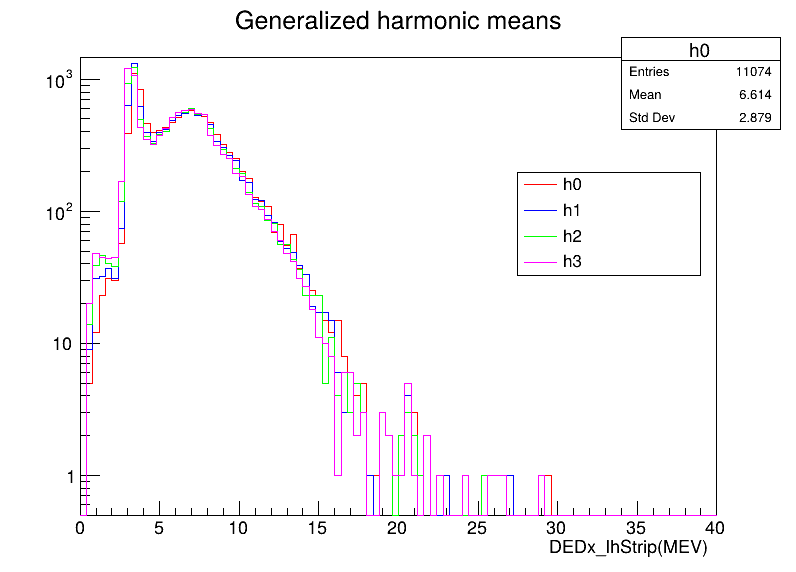

In [7]:



c = rt.TCanvas("h2_canvas_overlay","Log-scale overlay",800,600)
c.SetLogy()

leg = rt.TLegend(0.65,0.52,0.88,0.7)

hists = {} # dictionary to hold histogram names for harmonic2 DEDx track avergaes plot

for i, branch in enumerate(HMNCSBR):
    if i == 1:
        hists[f"h{i-1}"].SetTitle("Generalized harmonic means")
        hists[f"h{i-1}"].GetXaxis().SetTitle("DEDx_lhStrip(MEV)")
    hists[f"h{i}"] = df.Histo1D((f"h{i}","",100, 0, 40),branch)
    hists[f"h{i}"].SetLineColor(COLOR_MAP[i+1])
    hists[f"h{i}"].Draw("same")
    leg.AddEntry( hists[f"h{i}"].GetPtr(), f"h{i}", "l" )
    
max_vals = [h.GetMaximum() for h in hists.values()]
overall_max = max(max_vals)
hists["h0"].SetMaximum(overall_max * 1.1)


leg.Draw()

c.Draw()


utils.write_stacked_histos("h2_overlay", hists, hists["h0"].GetTitle(), c)

# # building a histogram stack and writing to the root file f_out points to

# stack = rt.THStack("h2_overlay", "Generalized harmonic means")

# for proxy in hists.values():
#     stack.Add(proxy.GetPtr()) #pyroot stores a pointer in the dictionary, I need to pull that out
    
# stack.Write()
# c.Write()

In [8]:
print(hists)

{'h0': <cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> object at 0x653f619b73e0>, 'h1': <cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> object at 0x653f62081ff0>, 'h2': <cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> object at 0x653f63ed8320>, 'h3': <cppyy.gbl.ROOT.RDF.RResultPtr<TH1D> object at 0x653f646e37d0>}


Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable
Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable


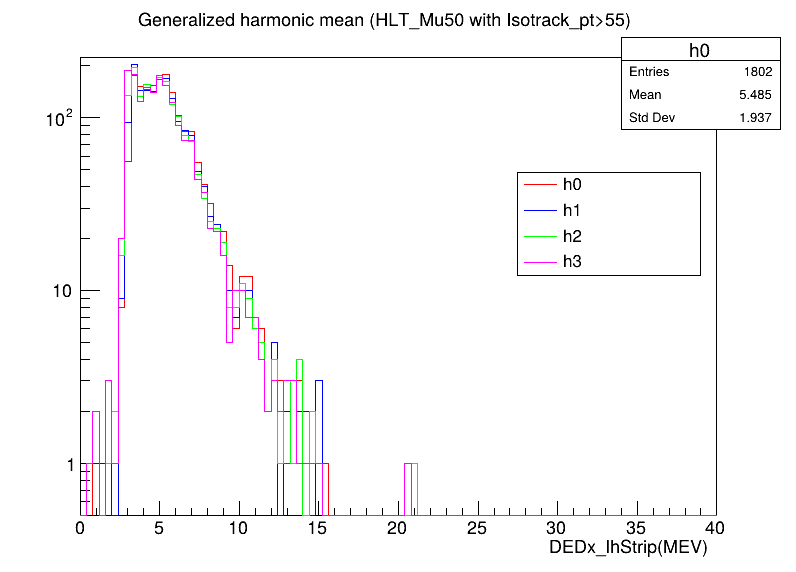

In [9]:

c = rt.TCanvas("h2_filtered_canvas_overlay","Log-scale overlay",800,600)
c.SetLogy()

leg = rt.TLegend(0.65,0.52,0.88,0.7)

hists = {} # dictionary to hold histogram names for harmonic2 DEDx track avergaes plot

for i, branch in enumerate(HMNCSBR):
    if i == 1:
        hists[f"h{i-1}"].SetTitle("Generalized harmonic mean (HLT_Mu50 with Isotrack_pt>55)")
        hists[f"h{i-1}"].GetXaxis().SetTitle("DEDx_lhStrip(MEV)")
    hists[f"h{i}"] = df_filtered.Histo1D((f"h{i}","",100, 0, 40),branch)
    hists[f"h{i}"].SetLineColor(COLOR_MAP[i+1])
    hists[f"h{i}"].Draw("same")
    leg.AddEntry( hists[f"h{i}"].GetPtr(), f"h{i}", "l" )
    
max_vals = [h.GetMaximum() for h in hists.values()]
overall_max = max(max_vals)
hists["h0"].SetMaximum(overall_max * 1.1)


leg.Draw()

c.Draw()

utils.write_stacked_histos("h2_filtered_overlay", hists, hists["h0"].GetTitle(), c)

Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable
Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable


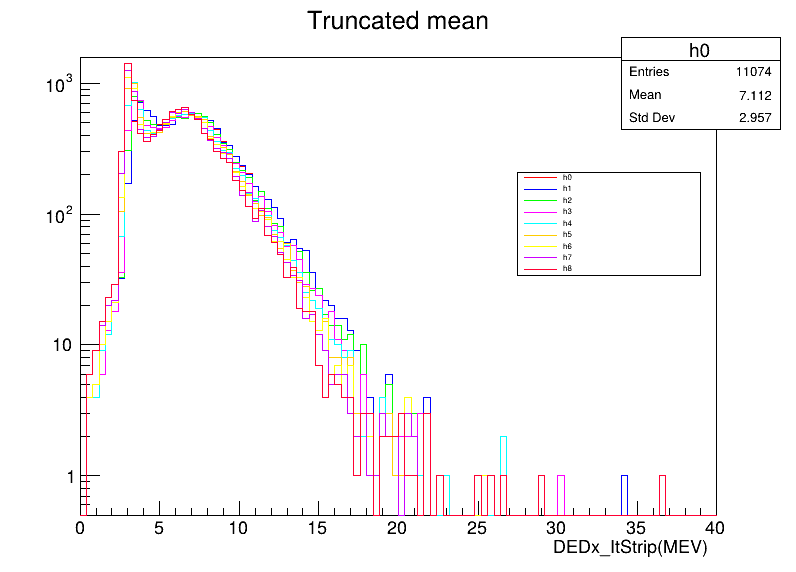

In [10]:

c = rt.TCanvas("Trunc_overlay_canvas","Log-scale overlay",800,600)
c.SetLogy()

leg = rt.TLegend(0.65,0.52,0.88,0.7)

hists = {} # dictionary to hold histogram names for truncated DEDx track avergaes plot


for i, branch in enumerate(TRUNCSBR):
    if i == 1:
        hists[f"h{i-1}"].SetTitle("Truncated mean")
        hists[f"h{i-1}"].GetXaxis().SetTitle("DEDx_ItStrip(MEV)")
    hists[f"h{i}"] = df.Histo1D((f"h{i}", "", 100, 0, 40), branch)
    hists[f"h{i}"].SetLineColor(COLOR_MAP[i+1])
    hists[f"h{i}"].Draw("same")
    leg.AddEntry( hists[f"h{i}"].GetPtr(), f"h{i}", "l" )

max_vals = [h.GetMaximum() for h in hists.values()]
overall_max = max(max_vals)
hists["h0"].SetMaximum(overall_max * 1.1)

leg.Draw()
c.Draw()

utils.write_stacked_histos("Trunc_overlay", hists, hists["h0"].GetTitle(), c)

Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable
Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable


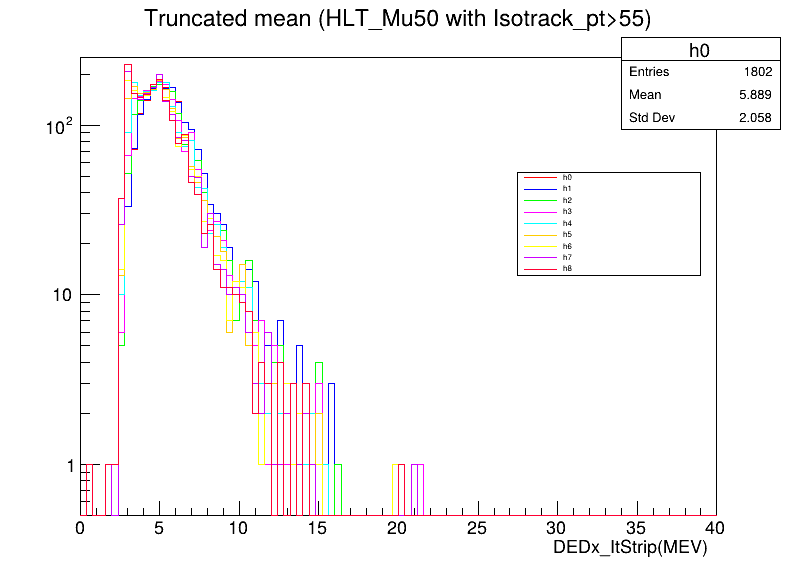

In [11]:

c = rt.TCanvas("Trunc_filtered_overlay_canvas","Log-scale overlay",800,600)
c.SetLogy()

leg = rt.TLegend(0.65,0.52,0.88,0.7)

hists = {} # dictionary to hold histogram names for truncated DEDx track avergaes plot

for i, branch in enumerate(TRUNCSBR):
    if i == 1:
        hists[f"h{i-1}"].SetTitle("Truncated mean (HLT_Mu50 with Isotrack_pt>55)")
        hists[f"h{i-1}"].GetXaxis().SetTitle("DEDx_ItStrip(MEV)")
    hists[f"h{i}"] = df_filtered.Histo1D((f"h{i}", "", 100, 0, 40), branch)
    hists[f"h{i}"].SetLineColor(COLOR_MAP[i+1])
    hists[f"h{i}"].Draw("same")
    leg.AddEntry( hists[f"h{i}"].GetPtr(), f"h{i}", "l" )

max_vals = [h.GetMaximum() for h in hists.values()]
overall_max = max(max_vals)
hists["h0"].SetMaximum(overall_max * 1.1)

leg.Draw()
c.Draw()

utils.write_stacked_histos("Trunc_filtered_overlay", hists, hists["h0"].GetTitle(), c)

In [12]:
#TODO: each histogram for each categorized mean, overlaid with it's filtered component, with their ratio and all 

In [ ]:
# f = rt.TFile(f"{output_root}/2025-06-23_histos.root") #opens up the root file for reading

# !rootls -t ../output/root/2025-06-23_histos.root

TCanvas  Jun 23 11:01 2025 h2_canvas_overlay;1             "Log-scale overlay" 
TCanvas  Jun 23 11:02 2025 h2_filtered_canvas_overlay;1    "Log-scale overlay" 
THStack  Jun 23 11:02 2025 h2_filtered_overlay;1           "Generalized harmonic mean (HLT_Mu50 with Isotrack_pt>55)" 
THStack  Jun 23 11:01 2025 h2_overlay;1                    "Generalized harmonic means" 
THStack  Jun 23 11:08 2025 Trunc_filtered_overlay;1        "Truncated mean (HLT_Mu50 with Isotrack_pt>55)" 
TCanvas  Jun 23 11:08 2025 Trunc_filtered_overlay_canvas;1 "Log-scale overlay" 
THStack  Jun 23 11:07 2025 Trunc_overlay;1                 "Truncated mean" 
TCanvas  Jun 23 11:07 2025 Trunc_overlay_canvas;1          "Log-scale overlay" 


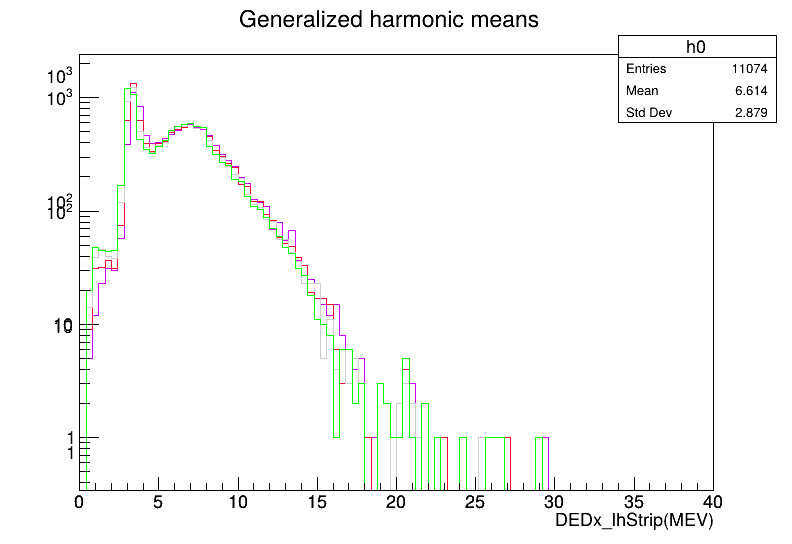

In [ ]:
# h2_stack = f.Get("h2_overlay")
# c = f.Get("h2_canvas_overlay")

# h2_stack.Draw("nostack")
# c.Draw()

In [ ]:
# h2_stack = f.Get("h2_overlay")
# h2_canvas = f.Get("h2_canvas_overlay")
# h2_hist_list = h2_stack.GetHists()


# h2_filtered_stack = f.Get("h2_filtered_overlay")
# h2_filtered_canvas = f.Get("h2_filtered_canvas_overlay")
# h2_filtered_hist_list = h2_filtered_stack.GetHists()


# trunc_stack = f.Get("Trunc_overlay")
# trunc_canvas = f.Get("Trunc_overlay_canvas")
# trunc_hist_list = trunc_stack.GetHists()


# trunc_filtered_stack = f.Get("Trunc_filtered_overlay")
# trunc_filtered_canvas = f.Get("Trunc_filtered_overlay_canvas")
# trunc_filtered_hist_list = trunc_filtered_stack.GetHists()

In [ ]:
#you have your two TH1*s to be overlaid
# h_num = h2_hist_list.At(0)
# h_den = h2_hist_list.At(3)


In [ ]:
%jsroot

def draw_two_ratio(h_num: rt.TH1, h_den: rt.TH1, 
                   option: str="pois", 
                   canvas_name: str="ratio", 
                   title: str="") -> rt.TCanvas:
    c = rt.TCanvas(canvas_name, title or canvas_name, 800,600)
    rp = rt.TRatioPlot(h_num, h_den, option)
    rp.Draw()
    c.Update()
    return rp
  
h = draw_two_ratio(h_num, h_den)


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 43 points have been skipped


In [26]:
c = rt.TCanvas()
h.Draw()
c.Draw()

In [18]:
%jsroot on

drawer = utils.HistogramDrawer()
a = drawer.draw_two_ratio(h_num, h_den)

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 43 points have been skipped


In [19]:
# close any existing canvases so ROOT will make a truly new one
for canv in rt.gROOT.GetListOfCanvases():
    canv.Close()


# 1) make your canvas
c = rt.TCanvas("c_ratio","Ratio Plot", 800, 800)

#create two pads: top (0.3–1) and bottom (0–0.3)
pad1 = rt.TPad("pad1", "Top pad", 0, 0.3, 1, 1)
pad2 = rt.TPad("pad2","Bottom pad", 0, 0,   1, 0.3)
pad1.SetBottomMargin(0)   # no x-axis tick labels
pad2.SetTopMargin(0.02)      # no title overlap
pad2.SetBottomMargin(0.4)    # room for x-axis label
pad1.Draw(); pad2.Draw()

#draw your two histos in pad1
pad1.cd()
pad1.SetLogy(1)              # if you want log-Y in the top
h_den.SetLineColor(rt.kBlack)
h_num.SetLineColor(rt.kRed)
# auto-scale so they both fit
maxval = max(h_den.GetMaximum(), h_num.GetMaximum())
h_den.SetMaximum(maxval*1.2)
h_den.SetTitle(f"Title")
h_den.GetYaxis().SetTitle("Number of tracks")
h_den.Draw()
h_num.Draw("same")
pad1.Update()


#build the ratio histogram in pad2
pad2.cd()
ratio = h_num.Clone("ratio")       # clone numerator
ratio.Divide(h_den)                # divide by denominator
ratio.SetMarkerStyle(20)           # draw as points
ratio.SetTitle("")                 # no global title
ratio.GetYaxis().SetTitle("Num/Den")
ratio.GetXaxis().SetTitle("DEDx_IhStrip (MeV/cm)")
# tweak axis label sizes so they’re big in the small pad:
ratio.GetYaxis().SetTitleSize(0.05)
ratio.GetYaxis().SetTitleOffset(0.4)
ratio.GetYaxis().SetLabelSize(0.05)
ratio.GetXaxis().SetTitleSize(0.08)
ratio.GetXaxis().SetLabelSize(0.08)

# set a sensible ratio range, e.g. 0.5–1.5
ratio.SetMinimum(-5)
ratio.SetMaximum(5)
ratio.Draw("EP")                   # E: error bars, P: points
pad2.Update()


#finally draw the overall canvas
c.cd()
c.Modified()
c.Draw()

In [20]:


N =  h2_hist_list.GetSize()
M = trunc_hist_list.GetSize()

In [21]:


cols = 2
rows = math.ceil(N/cols)

c = rt.TCanvas("c_all", "All Histograms", cols*800, rows*800)
c.Divide(cols, rows)

for i in range(N):
    pad = c.cd(i+1)
    pad.SetLogy(1)
    hist = h2_hist_list.At(i)
    hist_fltrd = h2_filtered_hist_list.At(i)
    
    hist.SetTitle(f"harmonic mean vs harmonic mean filtered (with harmonic power = -{i+1})")
    
    hist.SetLineColor(rt.kBlack)
    hist_fltrd.SetLineColor(rt.kRed)
    
    hist.GetXaxis().SetTitle("DEDX_IhStrip(MEV/cm)")
    hist.GetYaxis().SetTitle("Number of tracks")
    
    maxval = max(hist.GetMaximum(), hist_fltrd.GetMaximum())
    hist.SetMaximum(maxval * 1.2)
    
    hist.Draw("hist")
    hist_fltrd.Draw("hist same")
    
c.Modified()
c.Draw()

In [22]:
cols = 2
rows = math.ceil(M/cols)

c = rt.TCanvas("c_all", "All Histograms", cols*800, rows*800)
c.Divide(cols, rows)

for i in range(M):
    pad = c.cd(i+1)
    pad.SetLogy(1)
    hist = trunc_hist_list.At(i)
    hist_fltrd = trunc_filtered_hist_list.At(i)
    
    hist.SetTitle(f"Truncated mean vs Truncated mean filtered (last {i*5}% truncation)")
    hist.SetLineColor(rt.kBlack)
    hist_fltrd.SetLineColor(rt.kRed)
    
    hist.GetXaxis().SetTitle("DEDX_ItStrip(MEV/cm)")
    hist.GetYaxis().SetTitle("Number of tracks")
    
    maxval = max(hist.GetMaximum(), hist_fltrd.GetMaximum())
    hist.SetMaximum(maxval * 1.2)
    
    hist.Draw("hist")
    hist_fltrd.Draw("hist same")
    
c.Modified()
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_all


In [23]:
f.Close()


In [24]:
# closing the root file
#f_out.Close()